# **Import Libraries**

In [ ]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from tf_keras.utils import plot_model

# **Import Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
demand_df = pd.read_csv('/content/drive/MyDrive/TUGAS/CAPSTONE/demand_data.csv')

In [ ]:
demand_df.head()

,Date,Demand (kg)
0,January 2014,20481699.0
1,February 2014,21374931.0
2,March 2014,23005857.0
3,April 2014,23515279.0
4,May 2014,25569268.0


In [ ]:
demand_df.tail()

,Date,Demand (kg)
118,November 2023,41971838.26
119,December 2023,41495945.12
120,January 2024,48327679.13
121,February 2024,52134303.45
122,March 2024,53282356.51


In [ ]:
# Eliminate Date Column for Visualization
demand = np.array(demand_df['Demand (kg)'])
print(demand)

[20481699.   21374931.   23005857.   23515279.   25569268.   29263043.
 27078047.   33857112.   39784509.   35086060.   29092606.   28670166.
 28205901.99 28560210.52 28902614.27 31296079.02 21450479.34 23579920.82
 19596512.44 33192007.41 40201058.24 36009266.21 27424019.26 28669455.42
 24733267.78 27549982.63 25032436.21 25370388.09 22550600.27 30399442.52
 18395759.54 32754624.68 37306142.13 41814519.45 43380970.5  37168683.66
 33546774.85 31938317.98 40110454.49 29337557.02 31949037.93 17795837.44
 30801773.76 36822995.44 27281340.04 27414841.85 32054598.83 28188512.8
 30307036.99 28855110.64 26352025.42 22012539.88 23776653.29 15256076.54
 29366919.26 36634634.01 34956187.93 41264308.01 47542429.07 41984768.37
 28772491.43 25312733.96 27755292.21 24338323.5  34146740.36 21252422.94
 38264968.91 42035900.68 39932284.28 39453028.82 36826434.65 38865972.5
 34738627.2  37244783.46 32163233.19 33068775.5  24277766.79 28576346.19
 38276540.4  36077684.91 43817673.86 51558649.04 55027013

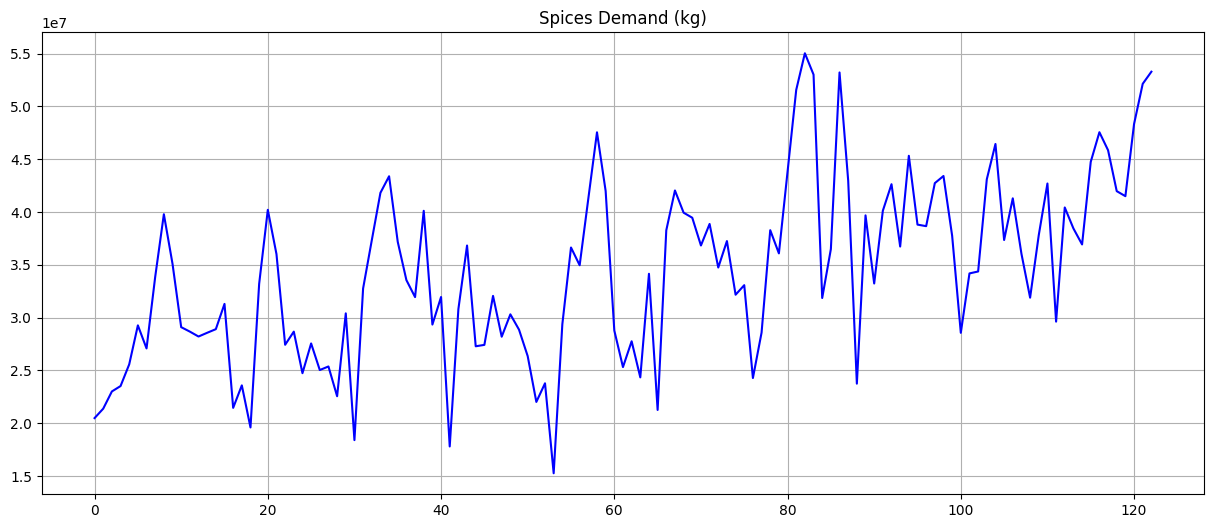

In [ ]:
# Visualize the Data
plt.subplots(figsize = (15,6))
sns.lineplot(x=range(len(demand)), y=demand, color='blue')

plt.grid()
plt.title('Spices Demand (kg)')
plt.show()

# **Exploratory Data Analysis**

## Statistical Analysis

In [ ]:
# Data Structure
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         123 non-null    object 
 1   Demand (kg)  123 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


Date change data type into datetime

In [ ]:
# Duplication
print("Duplication sum: ", demand_df.duplicated().sum())

Duplication sum:  0


In [ ]:
demand_df.describe(include='all')

,Date,Demand (kg)
count,123,1.230000e+02
unique,123,NaN
top,January 2014,NaN
freq,1,NaN
mean,NaN,3.432876e+07
std,NaN,8.501179e+06
min,NaN,1.525608e+07
25%,NaN,2.838192e+07
50%,NaN,3.418124e+07
75%,NaN,4.011336e+07


In [ ]:
# Missing Value
demand_df.isnull().sum()

Date           0
Demand (kg)    0
dtype: int64

In [ ]:
demand_df.shape

(123, 2)

There are 123 data (rows) with 2 columns

## Cleaning Data

In [ ]:
# Fixing Data Type
datetime_columns = ["Date"]

for column in datetime_columns:
  demand_df[column] = pd.to_datetime(demand_df[column])

<ipython-input-13-a891e2f689ec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_df[column] = pd.to_datetime(demand_df[column])


In [ ]:
#Recheck
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         123 non-null    datetime64[ns]
 1   Demand (kg)  123 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


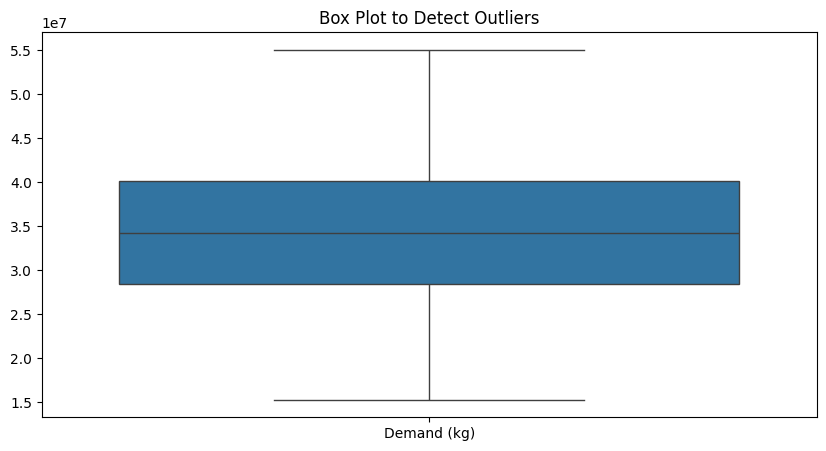

In [ ]:
# Box plot to visualize outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=demand_df)
plt.title('Box Plot to Detect Outliers')
plt.show()

# **Define Functions**

## Windowing

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

## Verification

In [ ]:
def verification(dataset, n_steps_in, n_lead_time, model):
  x_roll, y_roll = split_sequence(np.asarray(dataset), n_steps_in, n_steps_out)
  n = len(x_roll)-n_lead_time-1
  forecast_array = []
  actual_array = []

  for i in range(n):
    x = x_roll[i].reshape((1, n_steps_in, n_features))
    forecast = multi_step_forecasts(n_steps_in, n_lead_time, model, x)
    actual = y_roll[i:i+n_lead_time]
    forecast_array.append(forecast)
    actual_array.append(actual)

  forecast_array = np.array(forecast_array)
  actual_array = np.array(actual_array)

  df = pd.DataFrame(columns=['Lead Time no.', 'RMSE', 'MAPE', 'Pearson\'s Corr', 'R-Squared'])
  df['Lead Time no.'] = [i for i in range(1, n_lead_time + 1)]
  rmse = []
  mape = []
  corr = []
  rsq = []
  for j in range(n_lead_time):
    act_array = [actual_array[:,j][i][0] for i in range(len(actual_array[:,j]))]
    rmse.append(mean_squared_error(forecast_array[:,j], act_array, squared=False))
    mape.append(mean_absolute_percentage_error(forecast_array[:,j], act_array)*100)
    pearsonr_val, _ = pearsonr(forecast_array[:,j], act_array)
    corr.append(pearsonr_val)
    rsq.append(pearsonr_val**2)

  df['RMSE'] = rmse
  df['MAPE'] = mape
  df['Pearson\'s Corr'] = corr
  df['R-Squared'] = rsq

  return df

## Multi-Step Forecast

In [ ]:
def multi_step_forecasts(n_steps_in, n_forecast, model, data):

    x_forecast = data  # last observed input sequence

    y_future = []     # predicted target values

    for i in range(n_forecast):
        # generate the next forecast
        output = model.predict(x_forecast, verbose = 0)

        # save the forecast
        y_future.append(output[0][0])

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_steps_in:].reshape(1, n_steps_in, 1)

        x_forecast = x_forecast.reshape(x_forecast.shape[0], n_steps_in, 1)  # last observed input sequence

    return y_future

# **Pre-Processing Data**

## Scaling Data (Normalization)

In [ ]:
# Reshape the data to 2D
demand_reshaped = demand.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(demand_reshaped)

Scaling data using Minmax Value, so the data will change between range 0 to 1

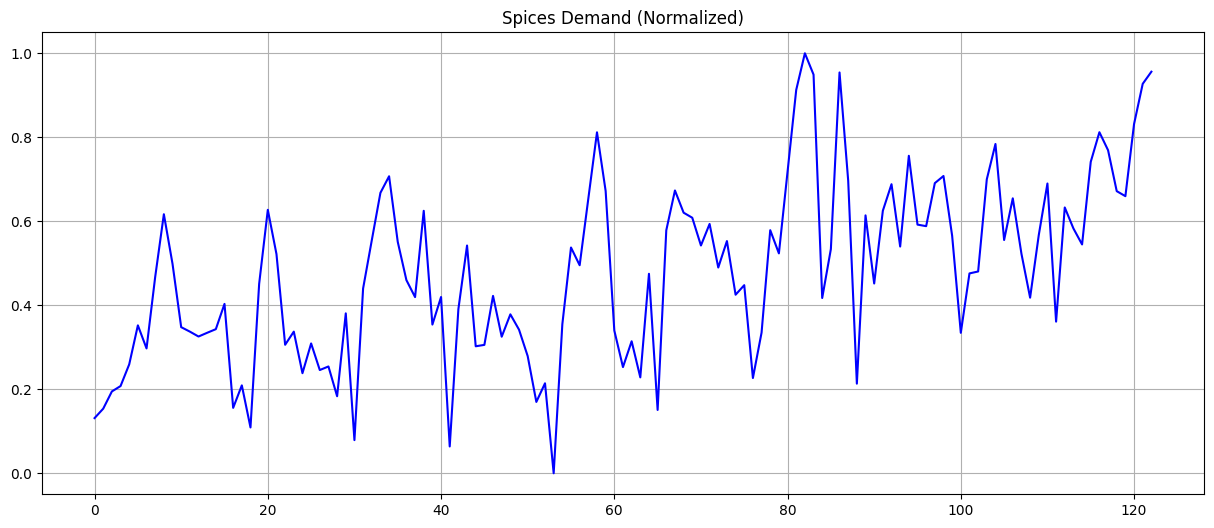

In [ ]:
# Flatten the scaled data
scaled_flattened = scaled.flatten()

# Visualization of the scaled data
plt.subplots(figsize=(15, 6))
sns.lineplot(x=range(len(scaled_flattened)), y=scaled_flattened, color='blue')

plt.grid()
plt.title('Spices Demand (Normalized)')
plt.show()

## Splitting data into Sequence

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define number of steps
n_steps_in, n_steps_out = 6, 3

# Split into samples
X, y = split_sequence(scaled, n_steps_in, n_steps_out)

# Print the data
for i in range(len(X)):
    print(X[i], y[i])

[[0.13139299]
 [0.15385241]
 [0.1948604 ]
 [0.2076693 ]
 [0.25931477]
 [0.35219101]] [[0.2972515 ]
 [0.46770423]
 [0.61674264]]
[[0.15385241]
 [0.1948604 ]
 [0.2076693 ]
 [0.25931477]
 [0.35219101]
 [0.2972515 ]] [[0.46770423]
 [0.61674264]
 [0.49860489]]
[[0.1948604 ]
 [0.2076693 ]
 [0.25931477]
 [0.35219101]
 [0.2972515 ]
 [0.46770423]] [[0.61674264]
 [0.49860489]
 [0.34790555]]
[[0.2076693 ]
 [0.25931477]
 [0.35219101]
 [0.2972515 ]
 [0.46770423]
 [0.61674264]] [[0.49860489]
 [0.34790555]
 [0.33728372]]
[[0.25931477]
 [0.35219101]
 [0.2972515 ]
 [0.46770423]
 [0.61674264]
 [0.49860489]] [[0.34790555]
 [0.33728372]
 [0.32561027]]
[[0.35219101]
 [0.2972515 ]
 [0.46770423]
 [0.61674264]
 [0.49860489]
 [0.34790555]] [[0.33728372]
 [0.32561027]
 [0.334519  ]]
[[0.2972515 ]
 [0.46770423]
 [0.61674264]
 [0.49860489]
 [0.34790555]
 [0.33728372]] [[0.32561027]
 [0.334519  ]
 [0.3431284 ]]
[[0.46770423]
 [0.61674264]
 [0.49860489]
 [0.34790555]
 [0.33728372]
 [0.32561027]] [[0.334519  ]
 [0.3

## Split Data into Training and Testing

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X to be 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Prepare the last n_steps_in values for future predictions
X_future = scaled[-n_steps_in:].reshape((1, n_steps_in, 1))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_future.shape)

print(y_train.shape)
print(y_test.shape)

(92, 6, 1)
(23, 6, 1)
(1, 6, 1)
(92, 3, 1)
(23, 3, 1)


Training Data = 92

Testing Data = 23

Future Data = 1

## Build The Model

In [ ]:
# define model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps_in, 1)),
    tf.keras.layers.Dense(n_steps_out)
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mse'])

In [ ]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10553 (41.22 KB)
Trainable params: 10553 (41.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


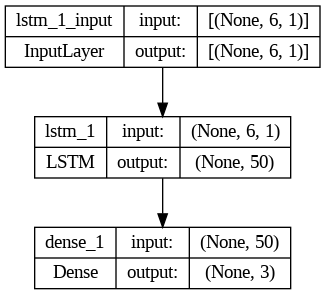

In [ ]:
# Plot the Model
plot_model(model, show_shapes=True, show_layer_names=True)

## Training the Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data = (X_test, y_test))

Epoch 1/200
3/3 [==============================] - 2s 158ms/step - loss: 0.1359 - mse: 0.2717 - val_loss: 0.1023 - val_mse: 0.2047
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1294 - mse: 0.2587 - val_loss: 0.0968 - val_mse: 0.1937
Epoch 3/200
3/3 [==============================] - 0s 17ms/step - loss: 0.1229 - mse: 0.2459 - val_loss: 0.0913 - val_mse: 0.1826
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1164 - mse: 0.2329 - val_loss: 0.0856 - val_mse: 0.1712
Epoch 5/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1096 - mse: 0.2191 - val_loss: 0.0797 - val_mse: 0.1594
Epoch 6/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1026 - mse: 0.2052 - val_loss: 0.0734 - val_mse: 0.1467
Epoch 7/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0947 - mse: 0.1894 - val_loss: 0.0664 - val_mse: 0.1329
Epoch 8/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0863 - mse: 0.1

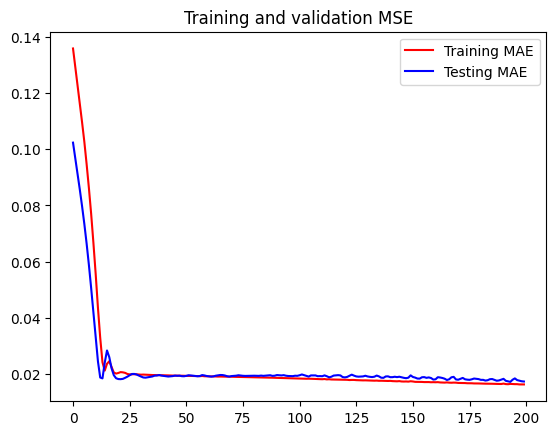

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot Loss Training and Testing
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Testing MAE')
plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()

plt.show()

## Evaluation

### Training Data

In [ ]:
forecast_train = model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [ ]:
frc_y_train = [forecast_train[i][0] for i in range(len(forecast_train))]

In [ ]:
act_y_train = [y_train[i][0] for i in range(len(y_train))]

In [ ]:
split_train = len(X) - (len(X) - len(X_train))

In [ ]:
print(demand_df['Date'].dtype)

datetime64[ns]


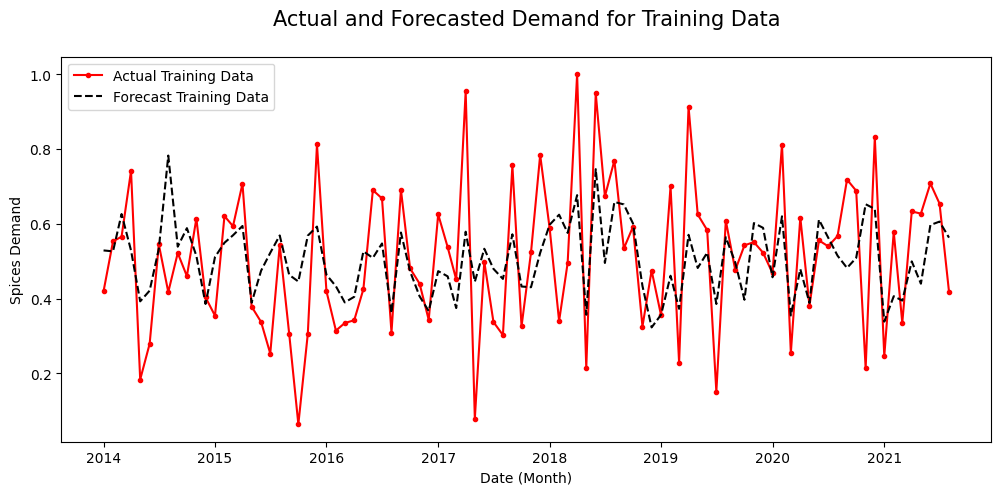

In [ ]:
plt.subplots(figsize=(12, 5))

plt.plot(demand_df["Date"][:split_train], act_y_train, label="Actual Training Data", marker='.', color='red')
plt.plot(demand_df["Date"][:split_train], frc_y_train, label="Forecast Training Data", linestyle="--", color='black')

plt.xlabel('Date (Month)')
plt.ylabel('Spices Demand')
plt.title("Actual and Forecasted Demand for Training Data\n", fontsize=15)
plt.legend(loc='upper left')

plt.show()

In [ ]:
rmse = mean_squared_error(frc_y_train, act_y_train, squared=False)
mae = mean_absolute_error(frc_y_train, act_y_train)
mape = mean_absolute_percentage_error(frc_y_train, act_y_train)*100
coefficient_of_dermination = r2_score(frc_y_train, act_y_train)

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,4))
print("Coefficient of Dermination: ", round(coefficient_of_dermination,4))

Forecast Train accuracy
RMSE:  0.1634
MAE:  0.1299
MAPE:  25.7938
Coefficient of Dermination:  -1.9612


### Testing Data

In [ ]:
forecast_test = model.predict(X_test)

1/1 [==============================] - 0s 19ms/step


In [ ]:
frc_y_test = [forecast_test[i][0] for i in range(len(forecast_test))]

In [ ]:
act_y_test = [y_test[i][0] for i in range(len(y_test))]

In [ ]:
# Convert datetime to string
demand_df["Date_str"] = demand_df["Date"].dt.strftime('%B %Y')
# Convert "Date_str" column to a list of strings
date_str_list = [str(date) for date in demand_df["Date_str"]]

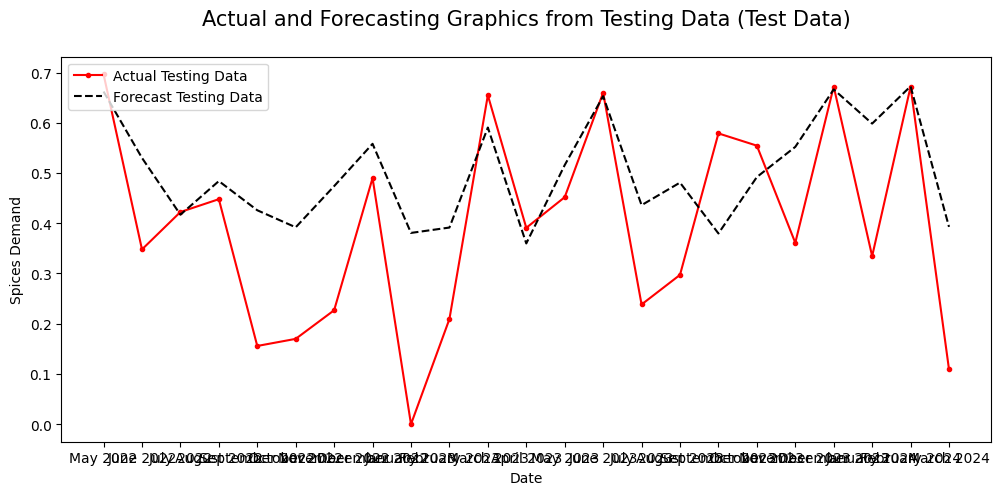

In [ ]:
plt.subplots(figsize=(12, 5))

# Plot actual testing data
plt.plot(date_str_list[-23:], act_y_test, label="Actual Testing Data", marker='.', color='red')

# Plot forecast testing data
plt.plot(date_str_list[-23:], frc_y_test, label="Forecast Testing Data", linestyle="--", color='black')

plt.xlabel('Date')
plt.ylabel('Spices Demand')
plt.title("Actual and Forecasting Graphics from Testing Data (Test Data)\n", fontsize=15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(frc_y_test, act_y_test, squared=False)
mae = mean_absolute_error(frc_y_test, act_y_test)
mape = mean_absolute_percentage_error(frc_y_test, act_y_test)*100
coefficient_of_dermination = r2_score(frc_y_test, act_y_test)

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,4))
print("Coefficient of Dermination: ", round(coefficient_of_dermination,4))

Forecast Test accuracy
RMSE:  0.1762
MAE:  0.1384
MAPE:  30.9909
Coefficient of Dermination:  -2.0598


# Forecasting

In [ ]:
print(X_future)

[[[0.7691531 ]
  [0.67174082]
  [0.65977497]
  [0.83155202]
  [0.92726574]
  [0.95613237]]]


In [ ]:
X_future_reshaped = np.asarray(X_future).reshape(-1, 1)

In [ ]:
scaler.inverse_transform(np.asarray(X_future_reshaped))

array([[45846015.83],
       [41971838.26],
       [41495945.12],
       [48327679.13],
       [52134303.45],
       [53282356.51]])

In [ ]:
real_forecast = multi_step_forecasts(6, 3, model, data = X_future)

In [ ]:
real_forecast

[0.7886756, 0.7560693, 0.7302473]

In [ ]:
# Reshape the array to make it 2-dimensional
real_forecast_reshaped = np.asarray(real_forecast).reshape(-1, 1)

In [ ]:
scaler.inverse_transform(np.asarray(real_forecast_reshaped))

array([[46622444.],
       [45325660.],
       [44298696.]], dtype=float32)

# Model Deployment

## Save the Model

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# Save the model in .h5 format
saved_model_path = "/content/drive/MyDrive/TUGAS/demand.h5"
model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TUGAS/demand.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10553 (41.22 KB)
Trainable params: 10553 (41.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Deployment using TF.js

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
    

In [ ]:
# Define the path to the model and the output directory
input_path = '/content/drive/MyDrive/TUGAS/demand.h5'
output_path = '/content/drive/MyDrive/TUGAS/tfjs_model'

# Convert the model
!tensorflowjs_converter --input_format=keras {input_path} {output_path}

2024-06-11 08:52:10.074853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os
if os.path.exists("/content/drive/MyDrive/TUGAS/tfjs_model"):
    print("Conversion successful, demand.json found")
else:
    print("Conversion failed, demand.json not found")

Conversion successful, demand.json found


In [ ]:
import shutil

# Define the name of the zip file
zip_path = '/content/drive/MyDrive/TUGAS/demand_tfjs.zip'

# Create a zip file
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', output_path)

print(f"Zip file created at: {zip_path}")

Zip file created at: /content/drive/MyDrive/TUGAS/demand_tfjs.zip
